In [1]:
import os, glob, shutil, random, pickle, time
import numpy as np
import shutil
import torch
import torch.nn
import torchvision.models as models
from torch.autograd import Variable 
import torch.cuda
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

from tqdm import tqdm
from skimage import io
import scipy.io as sio
import matplotlib.pyplot as plt
from functools import reduce
from skimage.morphology import binary_erosion, binary_dilation, disk
from scipy.ndimage import distance_transform_edt
from nudiff.image_syn.utils.datasets import get_hv
from nudiff.image_syn.utils.post_proc import get_instance_map

In [2]:
class ClusterDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform):
        self.imgs = sorted(glob.glob(f'{img_dir}/*.png'))
        self.labels = sorted(glob.glob(f'{label_dir}/*.tif'))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(self.imgs[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = io.imread(self.labels[idx])
        n_unique = len(np.unique(label))
        return img, label, n_unique, img_path

def extract_patches(image, shape, step_size):
    H, W = image.shape[:2]
    h, w = shape
    assert H >= h, 'image height < patch height!'
    assert W >= w, 'image width < patch width!'
    hstep, wstep = (H - h) // step_size + 1, (W - w) // step_size + 1
    hflag, wflag = ((H - h) % step_size != 0), ((W - w) % step_size != 0)
    # print(H, W, h, w, hstep, wstep, hflag, wflag)
    patches = []
    for i in range(hstep):
        for j in range(wstep):
            ytl, xtl = i * step_size, j * step_size
            ybr, xbr = ytl + h, xtl + w
            patch = image[ytl:ybr, xtl:xbr]
            patches.append(patch)
        if wflag:
            ytl, xtl = i * step_size, W - w
            ybr, xbr = ytl + h, W
            patch = image[ytl:ybr, xtl:xbr]
            patches.append(patch)
    if hflag:
        for j in range(wstep):
            ytl, xtl = H - h, j * step_size
            ybr, xbr = H, xtl + w
            patch = image[ytl:ybr, xtl:xbr]
            patches.append(patch)
    if hflag & wflag:
        patch = image[(H-h):H, (W-w):W]
        patches.append(patch)
    return patches

def relabel_instances(inst_map):
    new_map = np.zeros_like(inst_map)
    indices = np.unique(inst_map)
    n = 0
    for ind in indices:
        ind_map = inst_map == ind
        new_map[np.where(ind_map == True)] = n
        n += 1
    return new_map

def filter_patch(mask, prop=0.1, num=10):
    # print((mask != 0).sum()/mask.size)
    if (mask != 0).sum() / mask.size < prop or len(np.unique(mask)) - 1 < num:
        return False
    else:
        return True
    
def semantic_map(inst_map):
    sem = 255 * (inst_map > 0)
    return sem.astype('uint8')

# Pipeline
We take MoNuSeg dataset as an example to show the pipeline:

0. Data preprocess: Extract 256x256 patches and create 10%, 20%, 50%, 100% subsets.
1. Train DDPMs: Train unconditional DDPM (step1) and conditional DDPM (step2) for each proportion. The two DDPMs can be trained at the same time.
2. Generate synthetic samples: 
    * After training DDPMs, mannually select model checkpoints according to the visualization results (every 10000 steps). Typically, select step1 checkpoint >= 100000 steps, and step2 checkpoint >= 200000 steps.
    * Sample N synthetic nuclei structures with the selected step1 checkpoint. Also get instance maps from nuclei structures by watershed algorithm.
    * Sample N synthetic nuclei images conditioned on the N synthetic nuclei structures with the selected step2 checkpoint.
3. Train hover-net and test: It is recommended to go through this process with 10%/20%/50%/100% labeled to get the baseline segmentation performance, then 10%/20%/50%/100% augmented to compare with the baseline.

# 0. Data preprocess
Extract 256x256 patches, cluster, and select patches close to cluster centers such that 10%/20%/50%/100% subset has about 10%/20%/50%/100% nuclei instances of the original training set.

In [3]:
## use 256x256, 128 stride data
data_root = 'dataset/MoNuSeg/train' # path to monuseg training set
images = sorted(glob.glob(f'{data_root}/images/*.png'))
labels = sorted(glob.glob(f'{data_root}/labels/*.mat'))
print(len(images), len(labels))

16 16


(-0.5, 999.5, 999.5, -0.5)

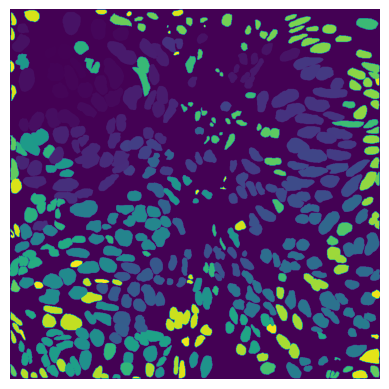

In [4]:
label = sio.loadmat(labels[0])
plt.imshow(label['inst_map'])
plt.axis('off')

In [12]:
## extract 256 patches from original images: no patch filtering
save_root = 'monuseg' # root directory for saving patches
split = 'train' # train or test
patch_size = (256, 256)
step_size = 128
base_dir = f'{save_root}/patches{patch_size[0]}x{patch_size[1]}_{step_size}/{split}'
save_img = f'{base_dir}/images'
save_inst = f'{base_dir}/instance_maps'
save_sem = f'{base_dir}/semantic_maps'
os.makedirs(save_img, exist_ok=True)
os.makedirs(save_inst, exist_ok=True)
os.makedirs(save_sem, exist_ok=True)
for n, (f1, f2) in enumerate(zip(images, labels)):
    name = os.path.basename(f1).split('.')[0]  # Use os.path.basename to handle both / and \ correctly
    image = io.imread(f1)
    label = sio.loadmat(f2)
    patches_ = extract_patches(image, patch_size, step_size)
    inst_maps_ = extract_patches(label['inst_map'], patch_size, step_size)
    # select patches
    # sel_ids = [i for i in range(len(patches_)) if filter_patch(inst_maps_[i]) is True]
    sel_ids = list(range(len(patches_)))
    patches = [patches_[i] for i in sel_ids]
    inst_maps = [inst_maps_[i] for i in sel_ids]
    # inst_maps = [relabel_instances(x).astype('int16') for x in inst_maps]
    sem_maps = [semantic_map(inst_map) for inst_map in inst_maps]
    print(f'Patches: {len(sel_ids)}/{len(inst_maps_)}')
    for k, patch in enumerate(patches):
        io.imsave(f'{save_img}/{name}_{k}.png', patch)
    for k, patch in enumerate(inst_maps):
        io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
    for k, patch in enumerate(sem_maps):
        io.imsave(f'{save_sem}/{name}_{k}.png', patch)
    print(n, '/', len(images))

Patches: 49/49


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-18-5592-01Z-00-DX1_0.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-18-5592-01Z-00-DX1_1.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-18-5592-01Z-00-DX1_2.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-18-5592-01Z-00-DX1_3.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarni

0 / 16
Patches: 49/49


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-38-6178-01Z-00-DX1_0.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-38-6178-01Z-00-DX1_1.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-38-6178-01Z-00-DX1_2.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-38-6178-01Z-00-DX1_3.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarni

1 / 16
Patches: 49/49


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-49-4488-01Z-00-DX1_0.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-49-4488-01Z-00-DX1_1.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-49-4488-01Z-00-DX1_2.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-49-4488-01Z-00-DX1_3.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarni

2 / 16
Patches: 49/49


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-50-5931-01Z-00-DX1_0.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-50-5931-01Z-00-DX1_1.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-50-5931-01Z-00-DX1_2.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-50-5931-01Z-00-DX1_3.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarni

3 / 16
Patches: 49/49


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-A7-A13E-01Z-00-DX1_0.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-A7-A13E-01Z-00-DX1_1.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-A7-A13E-01Z-00-DX1_2.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-A7-A13E-01Z-00-DX1_3.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarni

4 / 16
Patches: 49/49


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-A7-A13F-01Z-00-DX1_0.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-A7-A13F-01Z-00-DX1_1.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-A7-A13F-01Z-00-DX1_2.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-A7-A13F-01Z-00-DX1_3.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarni

5 / 16
Patches: 49/49


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-AR-A1AK-01Z-00-DX1_0.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-AR-A1AK-01Z-00-DX1_1.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-AR-A1AK-01Z-00-DX1_2.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-AR-A1AK-01Z-00-DX1_3.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarni

6 / 16
Patches: 49/49


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-AR-A1AS-01Z-00-DX1_0.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-AR-A1AS-01Z-00-DX1_1.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-AR-A1AS-01Z-00-DX1_2.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-AR-A1AS-01Z-00-DX1_3.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarni

7 / 16
Patches: 49/49


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-B0-5711-01Z-00-DX1_0.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-B0-5711-01Z-00-DX1_1.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-B0-5711-01Z-00-DX1_2.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-B0-5711-01Z-00-DX1_3.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarni

8 / 16
Patches: 49/49


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-G9-6336-01Z-00-DX1_0.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-G9-6336-01Z-00-DX1_1.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-G9-6336-01Z-00-DX1_2.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-G9-6336-01Z-00-DX1_3.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarni

9 / 16
Patches: 49/49


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-G9-6348-01Z-00-DX1_0.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-G9-6348-01Z-00-DX1_1.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-G9-6348-01Z-00-DX1_2.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-G9-6348-01Z-00-DX1_3.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarni

10 / 16
Patches: 49/49


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-G9-6356-01Z-00-DX1_0.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-G9-6356-01Z-00-DX1_1.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-G9-6356-01Z-00-DX1_2.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-G9-6356-01Z-00-DX1_3.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarni

11 / 16
Patches: 49/49


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-G9-6363-01Z-00-DX1_0.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-G9-6363-01Z-00-DX1_1.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-G9-6363-01Z-00-DX1_2.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-G9-6363-01Z-00-DX1_3.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarni

12 / 16
Patches: 49/49


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-HE-7128-01Z-00-DX1_0.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-HE-7128-01Z-00-DX1_1.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-HE-7128-01Z-00-DX1_2.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-HE-7128-01Z-00-DX1_3.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarni

13 / 16
Patches: 49/49


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-HE-7129-01Z-00-DX1_0.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-HE-7129-01Z-00-DX1_1.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-HE-7129-01Z-00-DX1_2.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-HE-7129-01Z-00-DX1_3.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarni

14 / 16
Patches: 49/49
15 / 16
15 / 16


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-HE-7130-01Z-00-DX1_0.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-HE-7130-01Z-00-DX1_1.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-HE-7130-01Z-00-DX1_2.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarning: monuseg/patches256x256_128/train/instance_maps/TCGA-HE-7130-01Z-00-DX1_3.tif is a low contrast image
  io.imsave(f'{save_inst}/{name}_{k}.tif', patch)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14540\3605521429.py:30: UserWarni

(-0.5, 255.5, 255.5, -0.5)

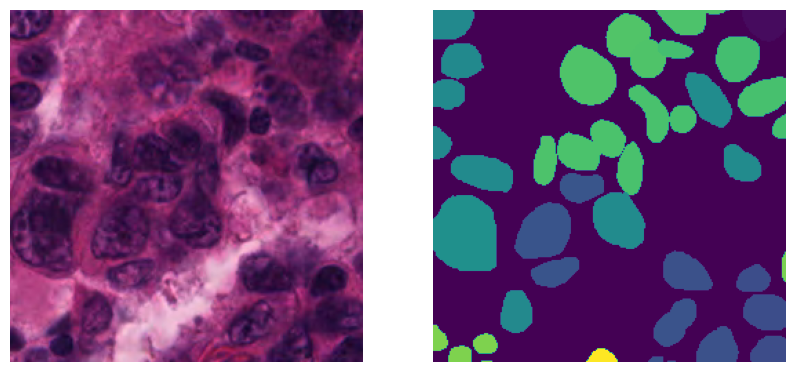

In [24]:
# In ra bất kỳ patches đã lưu
import random
import matplotlib.pyplot as plt
img_files = sorted(glob.glob(f'{save_img}/*.png'))
inst_files = sorted(glob.glob(f'{save_inst}/*.tif'))
rand_idx = random.randint(0, len(img_files)-1)
img = io.imread(img_files[rand_idx])
inst = io.imread(inst_files[rand_idx])
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(inst)
plt.axis('off')

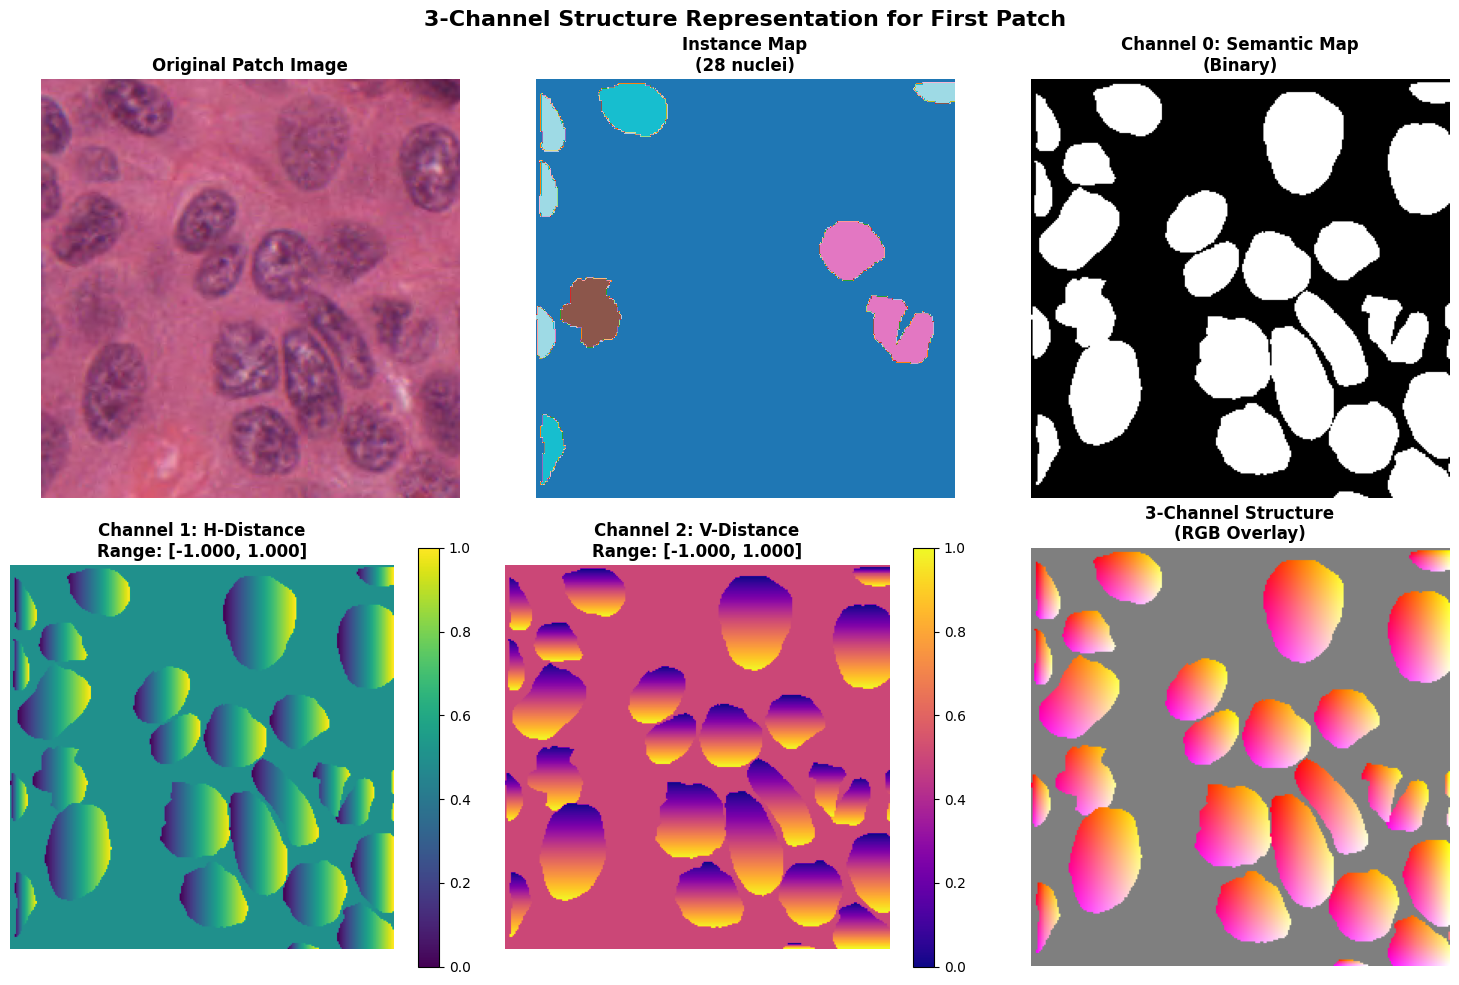


✓ Patch analysis completed:
  • Patch file: TCGA-18-5592-01Z-00-DX1_0
  • Image shape: (256, 256, 3)
  • Instance map shape: (256, 256)
  • Number of nuclei: 28
  • Semantic channel stats: min=0.0000, max=1.0000
  • H-Distance stats: min=-1.0000, max=1.0000, mean=0.0154
  • V-Distance stats: min=-1.0000, max=1.0000, mean=0.0118
  • Saved: first_patch_3_channels.png


In [25]:
# Hiển thị 3 kênh cho patch đầu tiên
# Load first patch image and structures
first_patch_img = sorted(glob.glob(f'{save_img}/*.png'))[0]
first_patch_name = os.path.basename(first_patch_img).split('.')[0]

# Load the actual patch image
patch_image = io.imread(first_patch_img)

# Build correct path for instance map (replace images/ with instance_maps/)
patch_inst_path = os.path.join(os.path.dirname(save_img), 'instance_maps', f'{first_patch_name}.tif')
patch_inst = io.imread(patch_inst_path)

# Generate 3-channel structure (semantic, h_dist, v_dist) using get_hv function
from nudiff.image_syn.utils.datasets import get_hv
hv_map = get_hv(patch_inst)  # Returns (h, w, 2) with [h_dist, v_dist]
h_dist = hv_map[..., 0]  # First channel: horizontal distance
v_dist = hv_map[..., 1]  # Second channel: vertical distance

# Create semantic map (binary: nucleus=1, background=0)
semantic = np.zeros_like(patch_inst, dtype=np.float32)
semantic[patch_inst > 0] = 1.0

# Stack into 3-channel structure
structure_3ch = np.stack([semantic, h_dist, v_dist], axis=-1)

# Create visualization with 6 subplots (paper style)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('3-Channel Structure Representation for First Patch', fontsize=16, fontweight='bold')

# Row 1: Original image and input
axes[0, 0].imshow(patch_image)
axes[0, 0].set_title('Original Patch Image', fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(patch_inst, cmap='tab20')
axes[0, 1].set_title(f'Instance Map\n({len(np.unique(patch_inst))-1} nuclei)', fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(semantic, cmap='gray')
axes[0, 2].set_title('Channel 0: Semantic Map\n(Binary)', fontweight='bold')
axes[0, 2].axis('off')

# Row 2: Distance transforms
h_dist_norm = (h_dist - h_dist.min()) / (h_dist.max() - h_dist.min() + 1e-8)
axes[1, 0].imshow(h_dist_norm, cmap='viridis')
axes[1, 0].set_title(f'Channel 1: H-Distance\nRange: [{h_dist.min():.3f}, {h_dist.max():.3f}]', fontweight='bold')
axes[1, 0].axis('off')
plt.colorbar(axes[1, 0].images[0], ax=axes[1, 0])

v_dist_norm = (v_dist - v_dist.min()) / (v_dist.max() - v_dist.min() + 1e-8)
axes[1, 1].imshow(v_dist_norm, cmap='plasma')
axes[1, 1].set_title(f'Channel 2: V-Distance\nRange: [{v_dist.min():.3f}, {v_dist.max():.3f}]', fontweight='bold')
axes[1, 1].axis('off')
plt.colorbar(axes[1, 1].images[0], ax=axes[1, 1])

# Combined 3-channel visualization
axes[1, 2].imshow(np.clip(structure_3ch * 0.5 + 0.5, 0, 1))
axes[1, 2].set_title('3-Channel Structure\n(RGB Overlay)', fontweight='bold')
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('first_patch_3_channels.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Patch analysis completed:")
print(f"  • Patch file: {first_patch_name}")
print(f"  • Image shape: {patch_image.shape}")
print(f"  • Instance map shape: {patch_inst.shape}")
print(f"  • Number of nuclei: {len(np.unique(patch_inst)) - 1}")
print(f"  • Semantic channel stats: min={semantic.min():.4f}, max={semantic.max():.4f}")
print(f"  • H-Distance stats: min={h_dist.min():.4f}, max={h_dist.max():.4f}, mean={h_dist.mean():.4f}")
print(f"  • V-Distance stats: min={v_dist.min():.4f}, max={v_dist.max():.4f}, mean={v_dist.mean():.4f}")
print(f"  • Saved: first_patch_3_channels.png")

In [16]:
## model
device = 'cuda:0' # set device
resnet = models.resnet50(pretrained=True)
modules = list(resnet.children())[:-1]     
model = nn.Sequential(*modules)
model.eval()
model.to(device)

c:\Users\ASUS\miniconda3\envs\nudiff\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\miniconda3\envs\nudiff\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [18]:
## dataset
split = 'train' # subsets are constructed with training patches
resnet_transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

# Fixed: Use the correct directory structure (patches not allpatch)
img_dir = f'{save_root}/patches{patch_size[0]}x{patch_size[1]}_{step_size}/{split}/images'
label_dir = f'{save_root}/patches{patch_size[0]}x{patch_size[1]}_{step_size}/{split}/instance_maps'

# Debug: Check if directories exist
print(f"Image directory: {img_dir}")
print(f"  Exists: {os.path.exists(img_dir)}")
print(f"  Files: {len(glob.glob(f'{img_dir}/*.png'))}")

print(f"Label directory: {label_dir}")
print(f"  Exists: {os.path.exists(label_dir)}")
print(f"  Files: {len(glob.glob(f'{label_dir}/*.tif'))}")

dataset = ClusterDataset(img_dir, label_dir, transform=resnet_transform)
loader = DataLoader(dataset, batch_size=49, shuffle=False)
print(f"\nDataset size: {len(dataset)}")
print(f"Dataset length: {len(dataset)}")

Image directory: monuseg/patches256x256_128/train/images
  Exists: True
  Files: 784
Label directory: monuseg/patches256x256_128/train/instance_maps
  Exists: True
  Files: 784

Dataset size: 784
Dataset length: 784


In [19]:
## get features
features, labels, n_uniques, img_paths = [], [], [], []
for i, (batch, label, n_unique, path) in enumerate(tqdm(loader)):
    batch = batch.to(device)
    feature = model(batch)
    features.append(feature.detach().cpu().numpy().squeeze())
    labels.append(label.detach().numpy())
    n_uniques.extend(n_unique.tolist())
    img_paths.extend(list(path))
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)
n_uniques = np.array(n_uniques)
img_paths = np.array(img_paths)

100%|██████████| 16/16 [01:03<00:00,  3.99s/it]



In [20]:
## cluster
K = 6
kmeans = KMeans(init="random", n_clusters=K, random_state=42)
t0 = time.time()
kmeans.fit(features)
print(f'{time.time() - t0:.2f}s')
p_labels = kmeans.labels_

c:\Users\ASUS\miniconda3\envs\nudiff\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ASUS\miniconda3\envs\nudiff\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ASUS\miniconda3\envs\nudiff\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\ASUS\miniconda3\envs\nudiff\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "

0.40s


In [21]:
## select patches close to class centers
chunks = np.split(np.arange(1470), 30)
prop = 1 # adjust this value such that instance percent is close to 0.1/0.2/0.5/1.0
props = [prop] * K
selected_ids = dict.fromkeys(list(range(K)))
all_ids = dict.fromkeys(list(range(K)))
inst_percents, inst_numbers, total_inst_number = [], [], 0
for k in tqdm(range(K)):
    # get close ids
    distances = pairwise_distances(kmeans.cluster_centers_[k][None,:], features[p_labels == k]).squeeze()
    cluster_ids = np.where(p_labels == k)[0]
    n_close = int(len(cluster_ids) * props[k])
    close_ids = cluster_ids[np.argsort(distances)[:n_close]]
    # calculate instance proportion
    close_unions, cluster_unions = [], []
    for i, chunk in enumerate(chunks):
        chunk_ids = [x for x in cluster_ids if x in chunk]
        if len(chunk_ids) > 0:
            cluster_union = np.unique(labels[chunk_ids])
            cluster_unions.append(len(cluster_union))
    for i, chunk in enumerate(chunks):
        chunk_ids = [x for x in close_ids if x in chunk]
        if len(chunk_ids) > 0:
            close_union = np.unique(labels[chunk_ids])
            close_unions.append(len(close_union))
    inst_percents.append(sum(close_unions) / sum(cluster_unions))
    inst_numbers.append(sum(close_unions))
    total_inst_number += sum(cluster_unions)
    selected_ids[k] = close_ids
    all_ids[k] = cluster_ids
global_percent = sum(inst_numbers) / total_inst_number
print(f'Global instance percent: {global_percent}')

100%|██████████| 6/6 [00:01<00:00,  3.83it/s]

Global instance percent: 1.0


In [23]:
## save patches for each proportion
# Fixed: Use correct directory names (patches not allpatch, instance_maps not instance_labels, semantic_maps not semantic_labels)
save_dir = f'{save_root}/patches{patch_size[0]}x{patch_size[1]}_{step_size}/train_6class_prop{global_percent:.2f}'
os.makedirs(save_dir, exist_ok=True)
os.makedirs(f'{save_dir}/images', exist_ok=True)
os.makedirs(f'{save_dir}/instance_maps', exist_ok=True)
os.makedirs(f'{save_dir}/semantic_maps', exist_ok=True)

for k in range(K):
    for path in tqdm(img_paths[selected_ids[k]]):
        # Fixed: Use os.path.basename() instead of split('/') to handle Windows backslashes
        name = os.path.basename(path).split('.')[0]
        
        # Copy image file
        shutil.copy(path, f'{save_dir}/images/{name}.png')
        
        # Copy instance map file (fixed directory: instance_maps not instance_labels)
        src_inst = f'{save_root}/patches{patch_size[0]}x{patch_size[1]}_{step_size}/{split}/instance_maps/{name}.tif'
        dst_inst = f'{save_dir}/instance_maps/{name}.tif'
        shutil.copy(src_inst, dst_inst)
        
        # Copy semantic map file (fixed directory: semantic_maps not semantic_labels)
        src_sem = f'{save_root}/patches{patch_size[0]}x{patch_size[1]}_{step_size}/{split}/semantic_maps/{name}.png'
        dst_sem = f'{save_dir}/semantic_maps/{name}.png'
        shutil.copy(src_sem, dst_sem)
    
    print(k)

100%|██████████| 116/116 [00:01<00:00, 92.73it/s]


0


100%|██████████| 71/71 [00:00<00:00, 110.31it/s]


1


100%|██████████| 180/180 [00:01<00:00, 95.76it/s]



2


100%|██████████| 187/187 [00:01<00:00, 101.09it/s]


3


100%|██████████| 50/50 [00:00<00:00, 104.67it/s]


4


100%|██████████| 180/180 [00:01<00:00, 105.19it/s]

5


# 1. Train
**!!! Attention**: The checkpoints will be saved every 10000 steps. This will consume a lot of storage space (hundreds of GB). You can type `df -h` to monitor the storage and can delete some early checkpoints (e.g checkpoints <100000 steps) to free storage space.

In [ ]:
data_root = 'monuseg/allpatch256x256_128' # directory saving training subsets of different labeling proportion

## 1.1 Nuclei structure synthesis

In [ ]:
gpu_id = 0
prop = 0.11
max_iterations = 200000
bs = 4
logdir = f'logs/monuseg_mask/prop{prop:.1f}' # logging directory
datadir = f'{data_root}/train_6class_prop{prop:.2f}' if prop < 1 else f'{data_root}/train'
assert os.path.exists(datadir)
print(os.path.exists(logdir))
command = f'CUDA_VISIBLE_DEVICES={gpu_id} OPENAI_LOGDIR={logdir} \
            python scripts/struct_syn/struct_train.py \
            --data_dir {datadir} \
            --attention_resolutions 32,16,8 --class_cond False --diffusion_steps 1000 --image_size 256 \
            --learn_sigma True --noise_schedule linear --num_channels 256 --num_head_channels 64 --num_res_blocks 2 \
            --resblock_updown True --use_fp16 True --use_scale_shift_norm True \
            --max_iterations {max_iterations} --batch_size {bs} --lr 1e-4 --weight_decay 0.05 \
            --save_interval 10000 --viz_interval 10000 --viz_batch_size 4'
print(command)

## 1.2 Nuclei image synthesis

In [ ]:
## Pretrain
prop = 0.11
gpu_id = 0
max_iterations = '150000'
bs = 1
logdir = f'logs/monuseg/prop{prop:.1f}_pretrain' # logging directory
datadir = f'{data_root}/train_6class_prop{prop:.2f}' if prop < 1 else f'{data_root}/train'
viz_datadir = f'{data_root}/test'
assert os.path.exists(datadir)
assert os.path.exists(viz_datadir)
print(os.path.exists(logdir))
command = f'CUDA_VISIBLE_DEVICES={gpu_id} OPENAI_LOGDIR={logdir} \
            python scripts/image_syn/train.py \
            --data_dir {datadir} \
            --viz_data_dir {viz_datadir} \
            --lr 1e-4 --batch_size {bs} --attention_resolutions 32,16,8 --diffusion_steps 1000 --image_size 256 --learn_sigma True \
            --noise_schedule linear --num_channels 256 --num_head_channels 64 --num_res_blocks 2 --resblock_updown True --use_fp16 True \
            --use_scale_shift_norm True --use_checkpoint False --num_classes 2 --class_cond True --no_instance False \
            --max_iterations {max_iterations} --save_interval 10000 --viz_interval 10000 --viz_batch_size 4'
print(command)

In [ ]:
## Finetune: classifier-free training (continue on the basis of the last checkpoint of the pretrain step)
prop = 0.11
gpu_id = 0
max_iterations = 300000
bs = 1
step = '150000' # set this to be max_iterations of the pretrain step
logdir = f'logs/monuseg/prop{prop:.1f}_finetune' # logging directory
datadir = f'{data_root}/train_6class_prop{prop:.2f}' if prop < 1 else f'{data_root}/train'
viz_datadir = f'{data_root}/test' # visualization directory
preckpt = f'logs/monuseg/prop{prop:.1f}_pretrain/model{step}.pt'
assert os.path.exists(datadir)
assert os.path.exists(viz_datadir)
assert os.path.exists(preckpt)
print(os.path.exists(logdir))
command = f'CUDA_VISIBLE_DEVICES={gpu_id} OPENAI_LOGDIR={logdir} \
            python scripts/image_syn/train.py \
            --data_dir {datadir} \
            --viz_data_dir {viz_datadir} \
            --resume_checkpoint {preckpt} \
            --unet unet \
            --lr 2e-5 --batch_size {bs} --attention_resolutions 32,16,8 --diffusion_steps 1000 --image_size 256 --learn_sigma True \
            --noise_schedule linear --num_channels 256 --num_head_channels 64 --num_res_blocks 2 --resblock_updown True --use_fp16 True \
            --use_scale_shift_norm True --use_checkpoint False --num_classes 2 --class_cond True --no_instance False --drop_rate 0.2 \
            --max_iterations {max_iterations} --save_interval 10000 --viz_interval 10000 --viz_batch_size 4'
print(command)

# 2. Sample

## 2.1 Nuclei structure synthesis

In [ ]:
gpu_id = 0
step1 = '150000' # select one checkpoint in step1
prop = 0.1
bs = 32
num_samples = 512
modelpath = f'logs/monuseg_mask/prop{prop:.1f}/model{step1}.pt'
resdir = f'results/monuseg_mask/prop{prop:.1f}/{step1}_{num_samples}'
assert os.path.exists(modelpath)
print(os.path.exists(resdir))
command = f'CUDA_VISIBLE_DEVICES={gpu_id} OPENAI_LOGDIR={resdir} \
            python scripts/struct_syn/struct_sample.py \
            --model_path {modelpath} --results_path {resdir} \
            --attention_resolutions 32,16,8 --class_cond False --diffusion_steps 1000 --image_size 256 --in_channels 3 \
            --learn_sigma True --noise_schedule linear --num_channels 256 --num_head_channels 64 --num_res_blocks 2 \
            --resblock_updown True --use_fp16 True --use_scale_shift_norm True \
            --batch_size {bs} --num_samples {num_samples}'
print(command)

In [ ]:
## get instance map from nuclei structures
prop = 0.11
datadir = f'results/monuseg_mask/prop{prop:.1f}/{step1}_{num_samples}'
inst_path = f'{datadir}/instances'
os.makedirs(inst_path, exist_ok=True)
files = sorted(glob.glob(f'{datadir}/samples/*.png'))
names = [x.split('/')[-1].split('.')[0] for x in files]
print(len(names))
masks = [io.imread(x) for x in files]
labels = []
for mask in tqdm(masks):
    label = get_instance_map(mask)
    labels.append(label)
for name, label in zip(names, labels):
    sio.savemat(f'{inst_path}/{name}.mat', {'inst_map': label})

## 2.2 Nuclei image synthesis

In [ ]:
gpu_id = 0
prop = 0.11
step2 = '150000' # select the checkpoint in step2
s = 2.0
num_samples = 512
modelpath = f'logs/monuseg/prop{prop:.1f}_finetune/model{step2}.pt'
datadir = f'results/monuseg_mask/prop{prop:.1f}/{step1}_{num_samples}/samples'
resdir = f'results/monuseg_mask/prop{prop:.1f}/{step1}_{num_samples}/finetune_{step2}_s{s}'
assert os.path.exists(modelpath)
assert os.path.exists(datadir)
print(os.path.exists(resdir))
command = f'CUDA_VISIBLE_DEVICES={gpu_id} OPENAI_LOGDIR={resdir} \
            python scripts/image_syn/sample.py \
            --data_dir {datadir} --model_path {modelpath} --results_path {resdir} --input_mask True \
            --attention_resolutions 32,16,8 --diffusion_steps 1000 --image_size 256 --learn_sigma True \
            --noise_schedule linear --num_channels 256 --num_head_channels 64 --num_res_blocks 2 --resblock_updown True --use_fp16 True \
            --use_scale_shift_norm True --num_classes 2 \
            --class_cond True --no_instance False --batch_size 28 --num_samples {num_samples} --s {s} --seed 0'
print(command)

# 3. Hover-net

## 3.1 Extract patches
Run the following commands under current directory.

In [ ]:
## you need to set paths in scripts/hovernet/extract_patches.py
command = 'python scripts/hovernet/extract_patches.py'
print(command)

## 3.2 Train
Run the following commands under current directory.

In [ ]:
## you need to set paths in scripts/hovernet/hovernet_config.py
command = 'python scripts/hovernet/train.py --gpu=0'
print(command)

## 3.3 Test
Run the following commands under the `hover_net` directory.

In [ ]:
## predict
prop = 0.11
epoch = 10 # select one checkpoint of hovernet according to validation metrics
# for 10%/20%/50%/100% labeled
dirname = f'monuseg_prop{prop:.1f}' 
# # for 10%/20%/50%/100% augmented
# num_samples = 512 # for example
# dirname = f'monuseg_prop{prop:.1f}+_syn_{num_samples}' 
segckpt = f'hovernet_logs/{dirname}/256x256_164x164/01/net_epoch={epoch}.tar'
assert os.path.exists(segckpt)
command = f'python run_infer.py \
            --gpu=0 \
            --model_path={segckpt} \
            --model_mode=fast --batch_size=64 \
            tile \
            --input_dir=/data/yuxinyi/MoNuSeg/test/images \
            --output_dir=hovernet_results/{dirname}/256x256_164x164'
print(command)

In [ ]:
## stats
command = f'python compute_stats.py \
            --mode instance \
            --true_dir /data/yuxinyi/MoNuSeg/test/labels \
            --pred_dir hovernet_results/{dirname}/256x256_164x164/mat'
print(command)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
x = ["10%", "20%", "50%", "100%"]
labeled = [0.7969, 0.8118, 0.8182, 0.8206]
augmented = [0.8291, 0.8219, 0.8291, 0.8336]
df = pd.DataFrame()
df['x'] = x 
df['labeled'] = labeled
df['augmented'] = augmented
df.to_csv('nudiff_results.csv', index=False)